#  GP latent function inference

This notebook uses GP to infer a latent function $\lambda(x)$, which parameterises the exponential distribution:
$$(y_1, y_2) \sim GaussianCopula(\lambda),$$
where:
$$\lambda = (2 \cdot \Phi(f) - 1) \in (-1,+1)$$
is a GP link function, which transforms the latent gaussian process variable:
$$f \sim GP \in (-\infty,+\infty).$$

In [1]:
import math
import torch
import pyro
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

from bvcopula import GaussianCopula, GaussianCopula_Likelihood, GPInferenceModel

pyro.enable_validation(True)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
#here we specify a 'true' latent function lambda
scale = lambda x: np.sin(2*np.pi*1*x)*1.+0.0

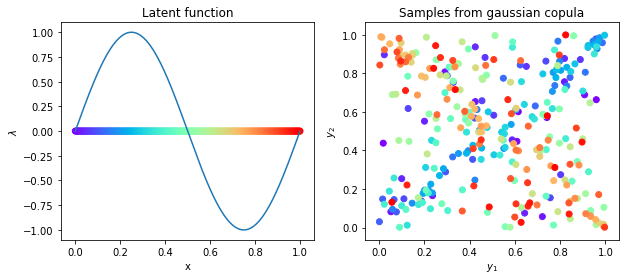

In [3]:
# here we generate some synthetic samples
from starvine.bvcopula.copula.gauss_copula import GaussCopula
import matplotlib.cm as cm

NSamp = 300

X = np.linspace(0,1,NSamp) 

fig, (lambdaf, samples) = plt.subplots(1,2,figsize=(10,4))

lambdaf.plot(X,scale(X))
lambdaf.set_xlabel('x')
lambdaf.set_ylabel('$\lambda$')
lambdaf.set_title('Latent function')

Y = np.zeros((NSamp,2))
copula = GaussCopula()
for i,x in enumerate(X):
    if scale(x) == 0:
        Y[i] = np.random.uniform(low=0,high=1,size=2)
    else:
        Y[i] = np.array(copula.sample(1,scale(x))).T # size=1
colors = cm.rainbow(np.linspace(0, 1, NSamp))
lambdaf.scatter(X,np.zeros_like(X),color=colors)
samples.scatter(*Y.T, color=colors)
samples.set_xlabel('$y_1$')
samples.set_ylabel('$y_2$')
samples.set_title('Samples from gaussian copula')

fig.show()

In [4]:
#convert numpy data to tensors (optionally on GPU)
train_x = torch.tensor(X).float()#.cuda(device=0)
train_y = torch.tensor(Y).float()#.cuda(device=0)

In [5]:
m = GaussianCopula(torch.tensor([0,-1,1,0.5,0.4,0.7]).float())
m.log_prob(m.sample().squeeze()).numpy()

array([0.        ,        inf,        inf, 0.38124883, 0.25448915,
       0.3606366 ], dtype=float32)

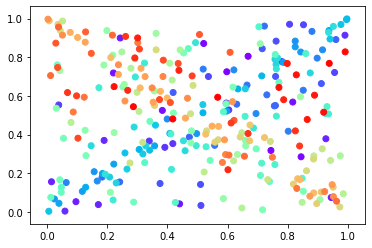

In [6]:
vec_scale = np.vectorize(scale)
scales = vec_scale(X)
m = GaussianCopula(torch.tensor(scales).float())#torch.ones(100)*0.7)
plt.scatter(*m.sample().numpy().T,color=colors)

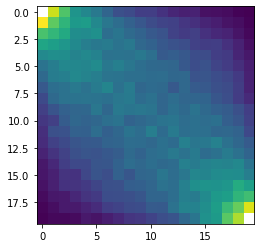

In [156]:
bin_size = 20
den = np.zeros((2,bin_size,bin_size))
copula = GaussCopula()
S = np.array(copula.sample(100000,0.5)).T
den[0] = np.histogram2d(*S.T,bins=[bin_size,bin_size],density=True)[0]
den[0,0,0] = den[0,-1,-1] = np.nan
plt.imshow(den[0])

In [ ]:
centre_bins = (np.mgrid[0:bin_size,0:bin_size]/bin_size + 1/2/bin_size).T
#plt.scatter(*centre_bins.reshape(-1,2).T)
samples = centre_bins.reshape(-1,2)
samples = torch.tensor(samples).float()
p_logpdf = copula.pdf(samples)
den[1] = p_logpdf.reshape(bin_size,bin_size)
den[1,0,0] = den[1,-1,-1] = np.nan
plt.imshow(den[1])

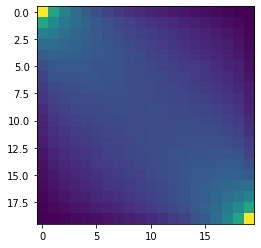

In [204]:
bin_size = 20
den = np.zeros((2,bin_size,bin_size))
m = GaussianCopula(torch.tensor(np.full(bin_size**2,0.5)).float())#torch.ones(100)*0.7)
S = m.sample(torch.Size([10000])).numpy().squeeze() # generates 100 x 100 (theta dim) samples
S = S.reshape(-1,2)
#plt.scatter(*S.T)
den[0] = np.histogram2d(*S.T,bins=[bin_size,bin_size],density=True)[0]
#den[0,0,0] = den[0,-1,-1] = np.nan
plt.imshow(den[0])

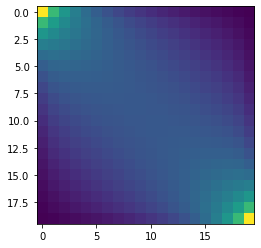

In [205]:
centre_bins = (np.mgrid[0:bin_size,0:bin_size]/bin_size + 1/2/bin_size).T
#plt.scatter(*centre_bins.reshape(-1,2).T)
samples = centre_bins.reshape(-1,2)
samples = torch.tensor(samples).float()
p_logpdf = np.exp(m.log_prob(samples).numpy())
den[1] = p_logpdf.reshape(bin_size,bin_size)
#den[1,0,0] = den[1,-1,-1] = np.nan
plt.imshow(den[1])

In [214]:
np.allclose(den[0][1:-1,1:-1],den[1][1:-1,1:-1],atol=0.05)
np.isclose(np.mean(den[0][1:-1,1:-1]-den[1][1:-1,1:-1]),0,atol=1e-4)


True

In [137]:
# define the model (optionally on GPU)
model = GPInferenceModel(train_x, train_y, GaussianCopula_Likelihood())#.cuda(device=0)

In [15]:
# train the model
from pyro import optim

base_lr = 1./NSamp
iter_print = 50

print('Basic lr for most of parameters: {}'.format(base_lr))

# set learning rates for different hyperparameters
def per_param_callable(module_name, param_name):
    if param_name == 'covar_module.base_kernel.raw_lengthscale':
        return {"lr": .1} #.1 for 256 particles
    elif param_name == 'variational_strategy.variational_distribution.variational_mean':
        return {"lr": .1}
    else:
        return {"lr": base_lr}

# Use the adam optimizer
optimizer = optim.Adam(per_param_callable)

pyro.clear_param_store() # clean run

losses, rbf, means = [], [], []

means.append(model.variational_strategy.variational_distribution.\
             variational_mean.detach().cpu().numpy()) #save initial mean

def train(num_iter=1500):
    elbo = pyro.infer.Trace_ELBO(num_particles=64, vectorize_particles=True)
    svi = pyro.infer.SVI(model.model, model.guide, optimizer, elbo)
    model.train()

    for i in range(num_iter):
        model.zero_grad()
        loss = svi.step(train_x, train_y)
        losses.append(loss)
        rbf.append(model.covar_module.base_kernel.lengthscale.item())
        if not (i + 1) % iter_print:
            print('Iter {}/{} - Loss: {:.3}   lengthscale: {:.3}'.format(
                i + 1, num_iter, loss,
                model.covar_module.base_kernel.lengthscale.item(),
            ))
            means.append(model.variational_strategy.variational_distribution.\
                         variational_mean.detach().cpu().numpy())
        
%time train()

Basic lr for most of parameters: 0.0033333333333333335
torch.Size([300]), torch.Size([300]), torch.Size([300, 2])
torch.Size([300]), torch.Size([64, 300]), torch.Size([300, 2])


IndexError: too many indices for tensor of dimension 1

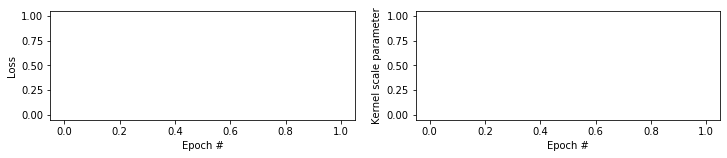

In [16]:
# prot loss function and kernel length
fig, (loss, kern) = plt.subplots(1,2,figsize=(12,2))
loss.plot(losses)
loss.set_xlabel("Epoch #")
loss.set_ylabel("Loss")
kern.plot(rbf)
kern.set_xlabel("Epoch #")
kern.set_ylabel("Kernel scale parameter")
fig.show()

In [17]:
# define test set (optionally on GPU)
denser = 2 # make test set 2 times denser then the training set
testX = np.linspace(0,1,denser*NSamp)
test_x = torch.tensor(testX).float()#.cuda()

/home/nina/.envs/GPyTorch/lib/python3.6/site-packages/gpytorch/lazy/cached_cg_lazy_tensor.py:161: UserWarning: CachedCGLazyTensor had to run CG on a tensor of size torch.Size([300, 1200]). For best performance, this LazyTensor should pre-register all vectors to run CG against.
  "LazyTensor should pre-register all vectors to run CG against.".format(rhs.shape)


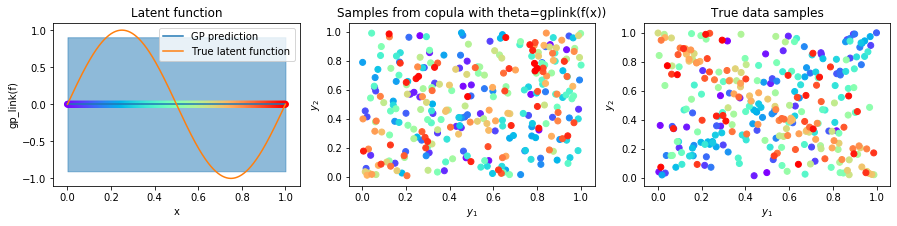

In [11]:
# visualize the result
fig, (func, sim, true) = plt.subplots(1,3,figsize=(15, 3))

model.eval()
with torch.no_grad():
    output = model(test_x)
    
gplink = model.likelihood.gplink_function
    
F_mean = gplink(output.mean).detach().cpu().numpy()
line, = func.plot(testX, F_mean, label = 'GP prediction')
lower, upper = output.confidence_region()
func.fill_between(testX, gplink(lower).detach().cpu().numpy(),
                gplink(upper).detach().cpu().numpy(), color=line.get_color(), alpha=0.5)

func.plot(testX,scale(testX), label = 'True latent function')
func.scatter(X,np.zeros_like(X),color=colors)
func.set_xlabel('x')
func.set_ylabel('gp_link(f)')
func.set_title('Latent function')
func.legend()

# sample from p(y|D,x) = \int p(y|f) p(f|D,x) (doubly stochastic)
with gpytorch.settings.num_likelihood_samples(1):
    Y_sim = model.likelihood(model(train_x)).rsample().detach().numpy()
true.scatter(*Y.T, label = 'True train data', color=colors)
sim.scatter(*Y_sim.T, label = 'Sample from the model', color=colors)
for ax in [sim,true]:
    ax.set_xlabel('$y_1$')
    ax.set_ylabel('$y_2$')
sim.set_title('Samples from copula with theta=gplink(f(x))')
true.set_title('True data samples')
# samp.legend()

fig.show()